# 摘要


# 理论模型

相比于股票，期货合约的最大不同在于因为到期日的缘故而有固定有效期。在任意一个日期，存在多个不同到期日的期货合约。到期日最近的合约称为近月合约(Nearby Contract)，其他称为远月合约（Far Contract）。在交易策略中的一个问题是选用哪个合约进行交易，从建模的角度是要处理有重叠区间的多个时间序列。

生成连续合约的难点在于不同到期日的期货合约价格不同。这是因为期货存在期限结构，近月升水称为 Backwardation，近月贴水称为 Contango，参见：[期货的期限结构](.\期限结构.ipynb)

不幸的是，没有生成连续合约的标准方法，这依赖于策略和交易使用合约的方式，常用的方法有如下。


## 简单拼接（Simple Splicing）

生成连续合约最简单的方法是将两个月合约的价格序列在切换日直接连接起来。这种方法没有解决合约切换日价格不连续的问题。

## 平移方法（Panama Adjustment）

在巴拿马运河（Panama Canal），船闸系统使船只能够上下浮动，以便在太平洋和大西洋之间通行，即使这两个水域的水位不同。

假设在 T 日发生了合约切换，老合约的切换价格为 $P_T$，新合约的切换价格为 $Q_T$，如果为了使得调整前后收益率保持不变，则：
* 前向调整（Last True Method）：T 日之前的合约价格减去 $P_T - Q_T$；
* 后向调整（First True Method）：T 日及其之后的所有股票价格加上 $P_T - Q_T$。

这种方法作用下，价格有可能为负，如要保证价格为正需要对所有的价格加上一个足够大的正数。该方法最大的问题是趋势偏差（Trend Bias）的引入，即造成价格序列一个较显著的漂移，并且不能直接使用连续合约的价格序列计算收益率序列。


## 比例方法（Proportional Adjustment）

该方法类似于处理股票的除权，可以使得调整前后收益率保持不变。

假设在 T 日发生了合约切换，老合约的切换价格为 $P_T$，新合约的切换价格为 $Q_T$，则：
* 前向调整（Last True Method）：T 日之前的价格乘以 $\frac{Q_T}{P_T}$；
* 后向调整（First True Method）：T 日及其之后的价格乘以 $\frac{P_T}{Q_T}$。

该方法主要的问题是对于依赖绝对价格水平的策略会产生错误的信号。此方法主要用于一些统计分析建模。

## Gann Series

Gann Series 方法用同一个到期月份的月合约价格序列相互连接生成连续合约。例如，将历史上所有 3 月份到期的合约价格序列首尾相连形成连续合约价格序列。该方法的优点是合约切换次数较少，价格序列连续的区间较长。然而，一个合约作为主力合约的时间较短，大部分时间处于不活跃状态，从而这种方法得到的连续合约在大部分时间区间里持仓量、成交量都较低，日内波动性很低，该连续合约的可交易性不大。

## Rollover/Perpetual Series

该方法是在切换前一段时间计算多个合约的线性加权组合价格序列作为连续合约的价格序列来平滑合约切换引起的跳跃。比如以切换前 5 个交易日作为平滑区间，在第一个交易日，以 8:2 的方式加权计算近月和远月合约价格作为连续合约价格，在第二天以 6:4 加权，第三天以 4:6 加权，第四天为 2:8，第五天为切换日权重为 0:10，即和新合约的价格一致。

以上几种连续合约构造方法的优劣对比：

|               方法               	|                      优势                      	|                                劣势                                	|
|:--------------------------------:	|:----------------------------------------------:	|:------------------------------------------------------------------:	|
|          Simple Splicing         	|          无价格调整，反映市场真实价格          	|                        合约切换时有价格缺口                        	|
|     Forward Panama Adjustment    	| 保持价格绝对变化量不变，不需要重新调整历史价格 	|   不能用于计算真实收益率，可能出现负值，不能反映当前市场真实价格   	|
|    Backward Panama Adjustment    	| 保持价格绝对变化量不变，当前价格是市场真实价格 	| 不能用于计算真实收益率，可能出现负值，需要不断重新计算所有历史价格 	|
|  Forward Proportional Adjustment 	|     保持收益率不变，不需要重新调整历史价格     	|             增加价格波动范围，不能反映当前市场真实价格             	|
| Backward Proportional Adjustment 	|     保持收益率不变，当前价格是市场真实价格     	|           增加价格波动范围，需要不断重新计算所有历史价格           	|
|            Gann Series           	|                减少合约切换次数                	|           生成的连续合约可能极度不活跃，无法用于现实交易           	|
|         Perpetual Series         	|           价格序列光滑，适合统计分析           	|                     不可交易性，引入了额外参数                     	|


## 指数合约

指数合约是指某品种上市的所有合约价格的加权汇总合约，但实际中并不存在指数合约这个交易标的，使用指数合约可以缓解合约切换的跳空影响。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

In [5]:
# 参数设置以及数据准备
CID = "IF.CFE"# 连续合约 ID
SpotID = "000300.SH"# 现货 ID

StartDT = dt.datetime(2010, 4, 16)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期

WDB.connect()
# 交易日序列
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid="CFFEX", start_dt=StartDT, end_dt=EndDT)
# 连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
MonthIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[CID], dts=DTs).iloc[0, :, 0]
MonthIDs = sorted(np.unique(MonthIDMap[pd.notnull(MonthIDMap)].values))
# 月合约到期日
FT = WDB.getTable("中国期货基本资料")
LastTradeDate = FT.readData(factor_names=["最后交易日期"], ids=MonthIDs, dts=[EndDT]).iloc[0, 0]
LastTradeDate = MonthIDMap.apply(lambda x: LastTradeDate[x] if pd.notnull(x) else None)
ExpirationDays = pd.Series([(dt.datetime.strptime(LastTradeDate.iloc[i], "%Y%m%d") - iDT).days for i, iDT in enumerate(DTs)], index=LastTradeDate.index)
# 价格数据
FT = WDB.getTable("中国股指期货日行情")
CPrice_SS = FT.readData(factor_names=["收盘价(元)"], ids=[CID], dts=DTs).iloc[0, :, 0]# Simple Splicing Continuous Contract
MonthPrice = FT.readData(factor_names=["收盘价(元)"], ids=MonthIDs, dts=DTs).iloc[0]
FT = WDB.getTable("中国A股指数日行情")
SpotPrice = FT.readData(factor_names=["收盘价(点)"], ids=[SpotID], dts=DTs).iloc[0, :, 0]
WDB.disconnect();

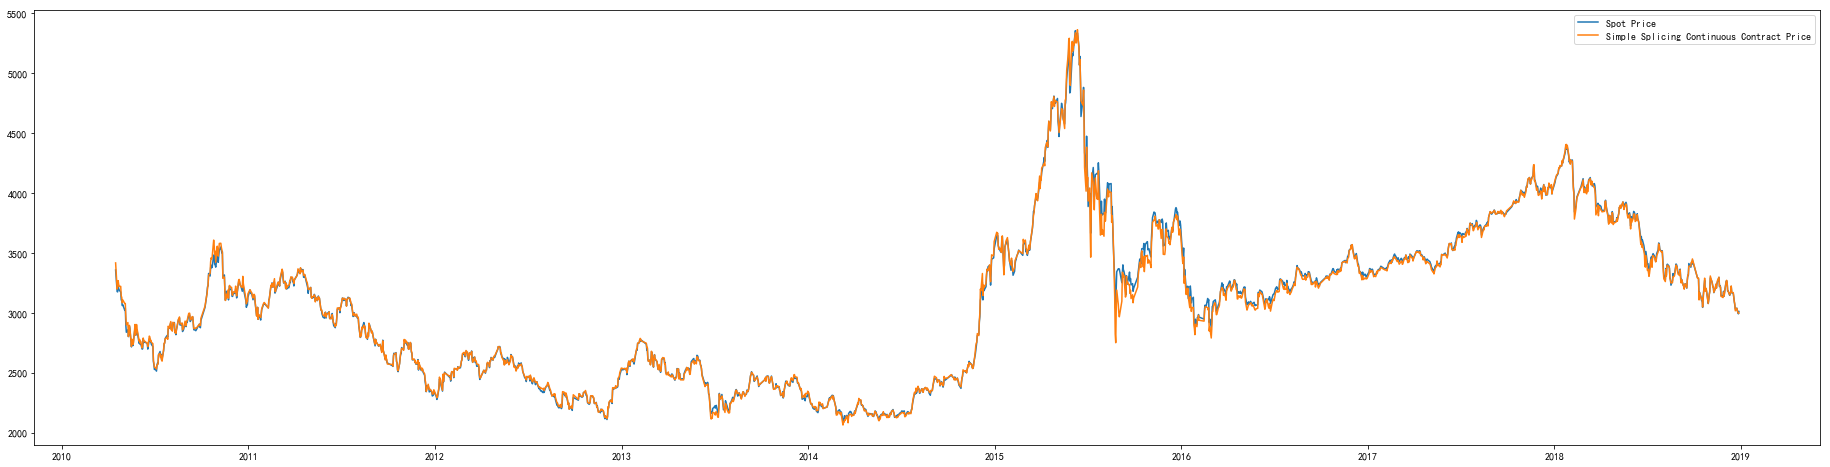

In [9]:
# Simple Splicing 价格序列
Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(SpotPrice, label="Spot Price")
Axes.plot(CPrice_SS, label="Simple Splicing Continuous Contract Price")
Axes.legend();

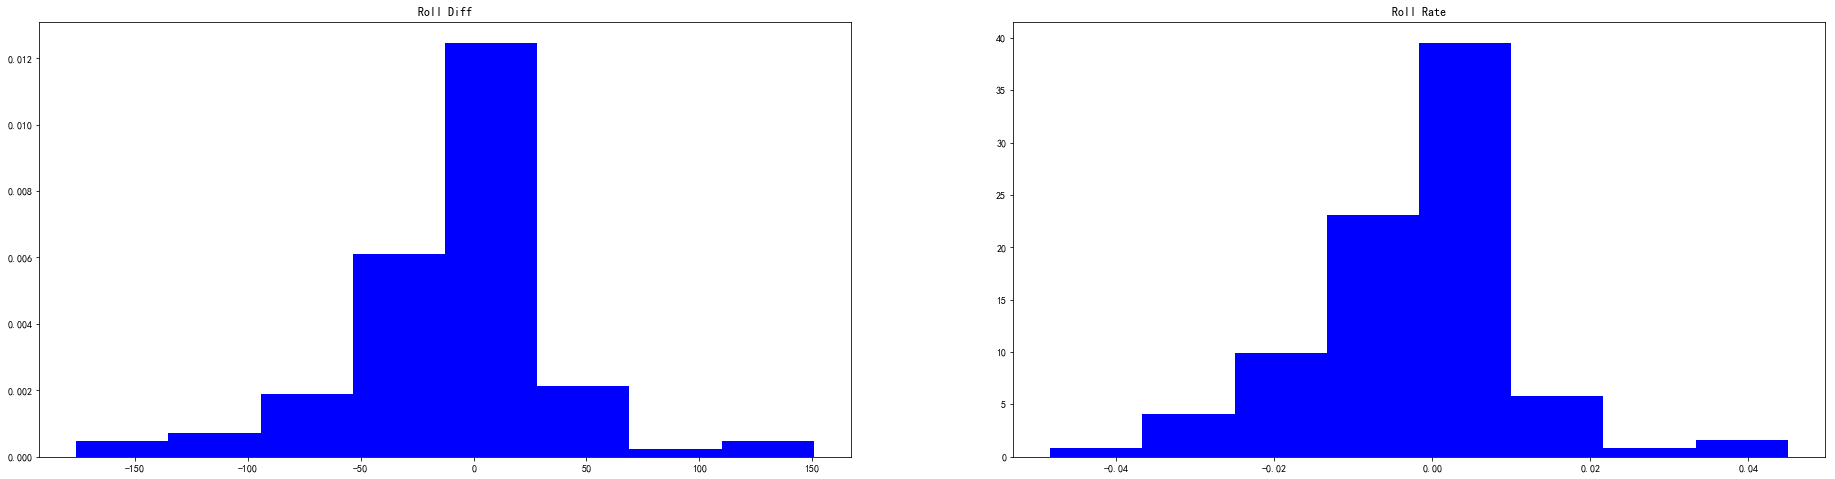

In [14]:
# 统计切换日价格跳跃
RollAhead = True
RollDTs, RollDiff, RollRate = [], [], []
for i, iDT in enumerate(DTs[1:]):
    iID, iPreID = MonthIDMap.iloc[i+1], MonthIDMap.iloc[i]
    if iID!=iPreID:# 合约切换日
        RollDTs.append(iDT)
        if RollAhead:
            RollDiff.append(MonthPrice[iID].iloc[i] - MonthPrice[iPreID].iloc[i])
            RollRate.append(MonthPrice[iID].iloc[i] / MonthPrice[iPreID].iloc[i] - 1)
        else:
            RollDiff.append(MonthPrice[iID].iloc[i+1] - MonthPrice[iPreID].iloc[i+1])
            RollRate.append(MonthPrice[iID].iloc[i+1] / MonthPrice[iPreID].iloc[i+1] - 1)

RollDiff = pd.Series(RollDiff, index=RollDTs)
RollRate = pd.Series(RollRate, index=RollDTs)

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].hist(RollDiff.values, 8, normed=True, label='RollDiff', color="b")
Axes[0].set_title("Roll Diff")
Axes[1].hist(RollRate.values, 8, normed=True, label='RollRate', color="b")
Axes[1].set_title("Roll Rate");